# 1. GAIN train and test example
## 1.1. Import all needed packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from fireman_imputation.src import utils
from fireman_imputation.gain_training import gain_train
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 1.2. Main

In [12]:
# load and scale the data
data_orig = pd.read_csv('data/spam.csv',index_col=False)
data = data_orig.values

# create missing data
data_missing, mask = utils.mcar_gen(data, 0.5)
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_missing)
data_missing = scaler.transform(data_missing)

# divide the data to train/test
# by default shuffles data, if pandas is passed the index shows shuffle result
data_missing_train, data_missing_test, data_train, data_test = train_test_split(data_missing, data, train_size=0.9)

# set hyper-parameters
gain_params = {'batch_size': 100,
               'hint_rate': 0.9,
               'alpha': 100,
               'epochs': 10,
               'learning_rate': 0.001}

# train the net
gen, disc = gain_train(gain_params, data_missing_train, cont=False)

# transform test data to tensor and forward it through generator
data_missing_test_torch, mask_test_torch = utils.gain_data_prep(data_missing_test)
data_imputed_test = gen(data_missing_test_torch, mask_test_torch)
data_imputed_test = data_imputed_test.detach().numpy()

# merge the imputed data(zero out rest in imputed data) and data with missing values
inv_mask_test = 1 - mask_test_torch.numpy()
# data_missing_test contains nan values
data_missing_test_0 = data_missing_test.copy()
data_missing_test_0[np.isnan(data_missing_test_0)] = 0
data_imputed_test = inv_mask_test*data_imputed_test + data_missing_test_0

# rescale the imputed data
data_imputed_test = scaler.inverse_transform(data_imputed_test)
data_missing_test = scaler.inverse_transform(data_missing_test)

# compute error
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
RMSE = mean_squared_error(data_test, data_imputed_test, squared=False)
print('RMSE of test dataset is {}'.format(RMSE))

RMSE of test dataset is 8.112603329137379


## 1.3. Visualize imputedt results

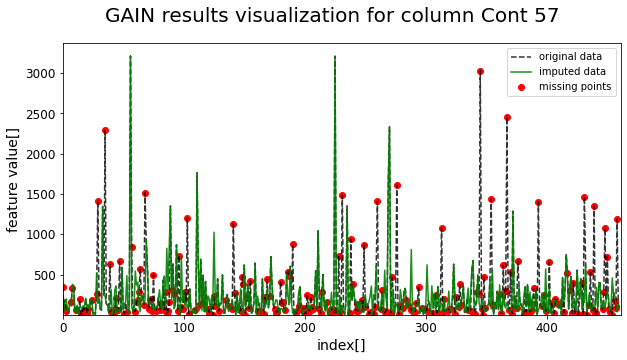

In [13]:
# create pandas for easier visualization
data_test_pd = pd.DataFrame(data_test, columns=data_orig.columns)
data_missing_test_pd = pd.DataFrame(data_missing_test, columns=data_orig.columns)
data_imputed_test_pd = pd.DataFrame(data_imputed_test, columns=data_orig.columns)

# define which column we want to plot and plot the plots :)
column = 'Cont 57'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('GAIN results visualization for column ' + column, size=20)

data_test_pd[column].plot(ax=ax, style='--', alpha=0.8, color='black', label='original data')
data_imputed_test_pd[column].plot(ax=ax, alpha=0.9, color='green', label='imputed data')

x = data_test_pd[data_missing_test_pd[column].isna()][column].index.values
y = data_test_pd[data_missing_test_pd[column].isna()][column].values
ax.scatter(x, y, color='red', label='missing points')
ax.set_xlim([0,len(data_imputed_test_pd)])
ax.set_ylim([data_imputed_test_pd[column].min()*0.95,data_imputed_test_pd[column].max()*1.05])
ax.tick_params(labelsize=12)
ax.set_xlabel('index[]',size=14)
ax.set_ylabel('feature value[]',size=14)

ax.legend();